# Quickstart

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# uncomment to disable NVIDIA GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# or pick the device (cpu, gpu, and tpu)
os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
os.environ['JAX_ENABLE_X64']= 'False'

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
jax.numpy.set_printoptions(precision=8)

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, linear_transfer,
    white_noise, white_noise_fixed,
    linear_modes, transfer,
    lpt,
    nbody,
    scatter,
    pm_util
)
from pmwd.vis_util import simshow
from pmwd.spec_util import powspec
from pmwd.pm_util import fftfreq, fftfwd, fftinv

In [4]:
BoxSize = 1000
grid = 256
kF = 2*np.pi/BoxSize
cell_spacing = BoxSize / grid
cell_spacing

3.90625

## Simulate Forward with $f_{NL}^{equil}$

`Configuration` stores static configuration and parameters for which we do not need derivatives.

In [5]:
if jax.lib.xla_bridge.get_backend().platform == 'gpu':
    ptcl_spacing = cell_spacing  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (grid,) * 3
else:
    ptcl_spacing = cell_spacing  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (grid,) * 3

conf = Configuration(ptcl_spacing,ptcl_grid_shape,mesh_shape=1,a_start=1/(1+127.),a_nbody_maxstep=0.09,a_stop=1.,lpt_order=2)  # 2x mesh shape

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=3.90625, ptcl_grid_shape=(256, 256, 256), mesh_shape=(256, 256, 256), cosmo_dtype=dtype('float64'), pmid_dtype=dtype('int16'), float_dtype=dtype('float32'), k_pivot_Mpc=0.05, T_cmb=2.7255, M=1.98847e+40, L=3.0856775815e+22, T=3.0856775815e+17, transfer_fit=True, transfer_fit_nowiggle=False, transfer_lgk_min=-4, transfer_lgk_max=3, transfer_lgk_maxstep=0.0078125, growth_rtol=1.4901161193847656e-08, growth_atol=1.4901161193847656e-08, growth_inistep=(1, None), lpt_order=2, a_start=0.0078125, a_stop=1.0, a_lpt_maxstep=0.0078125, a_nbody_maxstep=0.09, symp_splits=((0, 0.5), (1, 0.5)), chunk_size=16777216)
Simulating 16777216 particles with a (256, 256, 256) mesh for 12 time steps.


`Cosmology` stores interesting parameters, whose derivatives we need.

In [ ]:
cosmo = Cosmology.from_sigma8(conf, sigma8=0.834, n_s=0.9624, Omega_m=0.3175, Omega_b=0.049, h=0.6711, f_nl_loc_=None, f_nl_equi_=600.) #Careful: This only works when a_stop == 1. The a_stop !=1 case is patched in a different branch.

# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo)

Cosmology(A_s_1e9=Array(2.098, dtype=float64), n_s=Array(0.962, dtype=float64), Omega_m=Array(0.318, dtype=float64), Omega_b=Array(0.049, dtype=float64), h=Array(0.671, dtype=float64), Omega_k_=None, w_0_=None, w_a_=None, f_nl_loc_=None, f_nl_equi_=Array(600., dtype=float64), transfer=None, growth=None, varlin=None)


``boltzmann`` computes the transfer and growth functions and caches them in ``Cosmology``.

The first run is slower because it includes the **JIT compilation** time. JAX uses **asynchronous dispatch** to hide Python overheads. To measure the true cost, use ``DeviceArray.block_until_ready()`` to wait for the computation to complete.

In [8]:
cosmo = boltzmann(cosmo, conf)

In [9]:
print(cosmo.sigma8, cosmo.A_s_1e9)

0.8339999999999999 2.0984527741171592


Generate a white noise field and scale it with the linear power spectrum:

* We will compute Bispectrum measurements using the PBI4 lib. See usage [example](https://github.com/matteobiagetti/pbi4/blob/main/Tutorials/Notebook/test.ipynb).
* To reduce cosmic variance in the bispectrum measurements, we will make fixed & paired fields specifically to test the ICs.
 

In [ ]:
import pbi4 as pb
import json

pk_array = []
k_array = []
Bk_array = []

for i in range(20):
    seed = 10*i+5
    for p in range(2):
        print(f'\nseed {seed} - {p}')
        modes = white_noise_fixed(seed, conf)
        if p == 1:
            print('\npaired')
            modes = -modes
        modes = linear_modes(modes, cosmo, conf)

        # Solve LPT at some early time:
        ptcl, obsvbl = lpt(modes, cosmo, conf)

        # Finally, N-body time integration from the LPT initial conditions:
        #  ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf) 

        # Setup PBI4 for mesurements:
        io = pb.IO(config_file='config.json', verbose=False)
        params = io.read_params()

        # If any parameter in the config.json file is modified on the fly, it is necessary to re-load and update the parameters accordingly:
        # with open('config.json','w') as config_file:
        #     json.dump(params,config_file,indent = 4, cls=pb.NumpyArrayEncoder)
        # io=pb.IO(config_file = 'config.json',verbose = True)
        # params = io.read_params()
        
        pos = np.array(ptcl.pos()).T #in Mpc/h
        pos = np.minimum(1.-np.nextafter(0,1),pos/params['box']) #PBI4 interpolates particles in a units box [0,1)

        density = pb.DENSITIES(params,verbose=False)
        npart,dcl = density.assign_grid(pos)
        dcl = density.compute_density(npart,dcl)

        ms = pb.MEASUREMENTS(params)
        
        # compute the power spectrum:
        pout = ms.powerspectrum(npart,dcl)

        k_array.append(pout['avgk'])
        pk_array.append(pout['P0+PSN']*(2*np.pi)**3)

        # compute tringle configuration and then the bispectrum:
        counts = ms.triangle_counts()
        
        bs = ms.bispectrum(npart,counts,dcl,dcl,dcl)

        k1_array = bs['k1']
        k2_array = bs['k2']
        k3_array = bs['k3']
        Bk_array.append( (bs['B0+BSN']-bs['BSN'])*(2*np.pi)**6) #Shot noise subtracted B0

        del modes, ptcl, obsvbl, pos, npart, dcl, density

Bk_array = np.array(Bk_array)



seed 5 - 0
Computing equilateral non-Gaussian ICs...
Assigning 16777216 particles on the grid...
Done.
Computing final density.
FFTs...

Grid = 128
Fundamental frequency = 0.006283 h/Mpc
Nyquist frequency = 0.402124 h/Mpc
Running Fcomb...
Done.

kmin = 0.012566 h/Mpc
kmax = 0.402124 h/Mpc
Number of bins = 32
Computing real space power spectrum
Done.

 ---FORTRAN SUBROUTINE---
Computing real space bispectrum
 FFT grid =          128
 Allocate all arrays
 Find modes of amplitude |k|
 Save coordinates
 Make FFT plans
 FFT Threads:           16
 Calculate k maps
 Compute counts
  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 9

Now, let's display the power spectrum and bispectrum measurements, beginning with the powerspectrum:

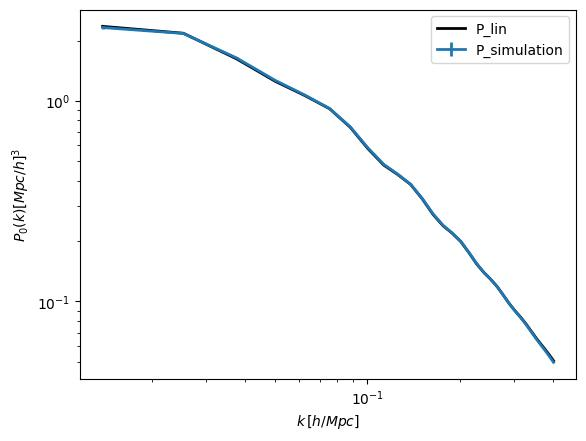

In [21]:
plin = linear_power(k_array[0], conf.a_start, cosmo, conf)

plt.plot(k_array[0], plin, 'k', lw=2, label='P_lin')
plt.errorbar(k_array[0], np.mean(pk_array,axis=0),np.std(pk_array,axis=0), lw=2,  label='P_simulation')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$k\,[h/Mpc]$')
plt.ylabel('$P_0(k)[Mpc/h]^3$')
plt.legend()
plt.show()

This is expected, as by design, the simulation is constructed to maintain a fixed amplitude defined by the analytical power spectrum.

Next, let's display the bispectrum measurements.

To compare the PNG signal in the ICs, we will use the analytical template as a reference baseline.

In [ ]:
def primordial(k, h=0.6711, A_s=2.09845277e-9, n_s=0.9624, k_p=0.05):
    return 2*np.pi**2*(k/k_p/h)**(n_s-1)*A_s/k**3


def Bispectrum_theory(klin,pklin,k1,k2,k3):
    ''' Compute the tree level bispectrum F2N*PS*PS + perm.
    k,Pk: linear powerpsectrum
    k1,k2,k3: wavenumber in h/Mpc
    '''
    F2 = lambda k1,k2,k3: 5/7+1/2*(k3**2-k2**2-k1**2)/2/k1/k2*(k1/k2+k2/k1)+2/7*((k3**2-k2**2-k1**2)/2/k1/k2)**2 #Newtonian second order kernel F2(k1,k2)

    Pk1 = np.interp(np.log(k1), np.log(klin), pklin)
    Pk2 = np.interp(np.log(k2), np.log(klin), pklin)
    Pk3 = np.interp(np.log(k3), np.log(klin), pklin)

    return 2*(Pk1*Pk2*F2(k1,k2,k3) + Pk1*Pk3*F2(k1,k3,k2) + Pk3*Pk2*F2(k2,k3,k1))

def Bispectrum_equilateral(k1,k2,k3,fnl):
    ''' Compute the equilateral bispectrum template:
                18/5*fnl{-(P1P2+cyc.) - 2(P1P2P3)^(2/3) + (P1^(1/3)P2^(2/3)P3 + cyc.)}
    k1,k2,k3: wavenumber in h/Mpc
    fnl: f_nl amplitude
    '''
    t1 = linear_transfer(k1, conf.a_start, cosmo, conf)*k1*k1 # The scale factor is hardcoded to test the ICs.
    t2 = linear_transfer(k2, conf.a_start, cosmo, conf)*k2*k2
    t3 = linear_transfer(k3, conf.a_start, cosmo, conf)*k3*k3

    kernel_pot = -primordial(k1)*primordial(k2) - primordial(k1)*primordial(k3) - primordial(k3)*primordial(k2)
    kernel_sym = -2*(primordial(k1)*primordial(k2)*primordial(k3))**(2./3)
    kernel_scalar_nabla = primordial(k1)**(1/3)*primordial(k2)**(2/3)*primordial(k3) + primordial(k2)**(1/3)*primordial(k1)**(2/3)*primordial(k3) \
            +primordial(k3)**(1/3)*primordial(k2)**(2/3)*primordial(k1) + primordial(k1)**(1/3)*primordial(k3)**(2/3)*primordial(k2) \
            +primordial(k2)**(1/3)*primordial(k3)**(2/3)*primordial(k1) + primordial(k3)**(1/3)*primordial(k1)**(2/3)*primordial(k2)
    
    return 18/5*fnl*(kernel_pot+kernel_sym+kernel_scalar_nabla)*t1*t2*t3

To plot the bispectrum measurements, we will compute the mean of the fixed and its paired simulation. Then, we will calculate the overall mean and the error over the mean of these paired and fixed simulations.

In [29]:
kf = 2*np.pi/1000

mean_bks = np.array(Bk_array).reshape(20, 2, 1056).mean(axis=1)
bs_data = mean_bks.mean(axis=0)
bs_err = mean_bks.std(axis=0)

r2 = k2_array/k1_array
r3 = k3_array/k1_array


klin = np.logspace(-3,1,1000)
plin = linear_power(klin, conf.a_start, cosmo, conf)

Let's start by displaying all the triangle configurations generated by PBI4 and comparing them with the analytical expression mentioned above.

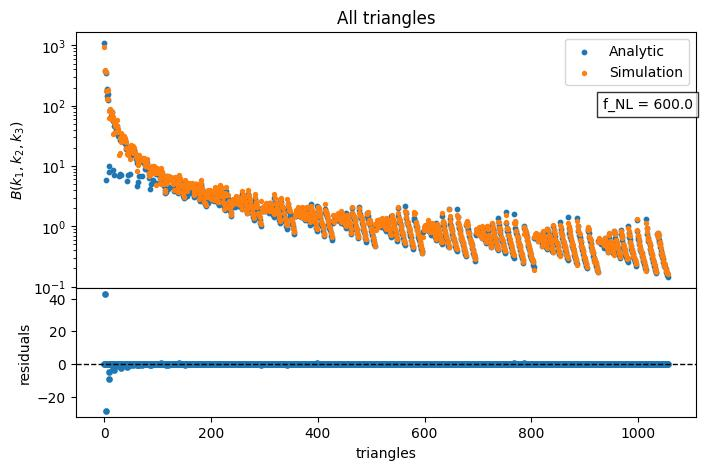

In [ ]:
mask = np.ones_like(bs_data,dtype=bool)
bequilateral = Bispectrum_equilateral(k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf, cosmo.f_nl_equi)
btree = Bispectrum_theory(klin, plin, k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf)
bs_model = btree + bequilateral
kk = np.arange(bs_model.shape[0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                               gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)


ax1.scatter(kk, bs_model, color = 'C0', label='Analytic',s=10)
ax1.scatter(kk, bs_data[mask], color = 'C1', label='Simulation',s=8)

ax1.set_yscale('log')
ax1.set_ylabel(r'$B(k_1,k_2,k_3)$')
ax1.legend()

ax1.text(0.85, 0.7, f'f_NL = {cosmo.f_nl_equi}',transform=ax1.transAxes,bbox=dict(facecolor='white', alpha=0.8, edgecolor='k'))


ax2.scatter(kk, 1-bs_data[mask]/bs_model, lw=2,s=8)
ax2.axhline(0, lw=1, color='k', ls='--')

ax2.set_xscale('linear')

ax2.set_ylabel('residuals')
ax2.set_xlabel('triangles')


ax1.set_title('All triangles')
plt.show()


Let's focus on the first 50 triangles to examine the details in the tail region

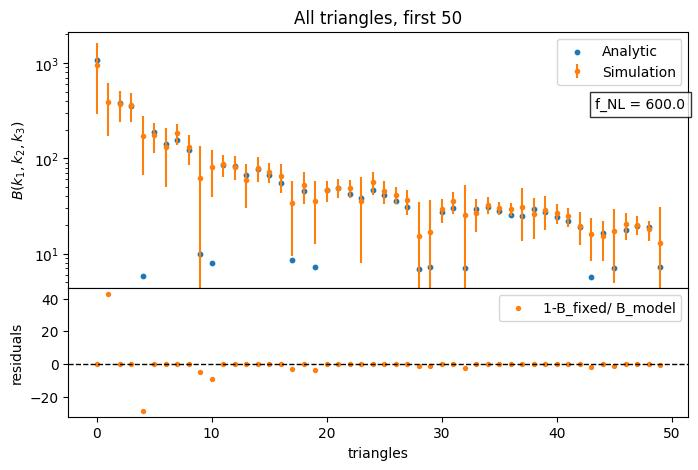

In [ ]:
mask = np.ones_like(bs_data,dtype=bool)
bequilateral = Bispectrum_equilateral( k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf, cosmo.f_nl_equi)
btree = Bispectrum_theory(klin, plin, k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf)
bs_model = btree + bequilateral
kk = np.arange(bs_model.shape[0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                               gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)

ax1.scatter(kk[:50], bs_model[:50], color = 'C0', label='Analytic',s=10)
ax1.errorbar(kk[:50], bs_data[mask][:50],bs_err[mask][:50], color = 'C1',ls='', marker='.', label='Simulation')

ax1.set_yscale('log')
ax1.set_ylabel(r'$B(k_1,k_2,k_3)$')
ax1.legend()

ax1.text(0.85, 0.7, f'f_NL = {cosmo.f_nl_equi}',transform=ax1.transAxes,bbox=dict(facecolor='white', alpha=0.8, edgecolor='k'))


ax2.scatter(kk[:50], 1-bs_data[mask][:50]/bs_model[:50], color = 'C1',label=f'1-B_fixed/ B_model',s=8)
ax2.axhline(0, lw=1, color='k', ls='--')

ax2.legend()
ax2.set_xscale('linear')
ax2.set_ylabel('residuals')
ax2.set_xlabel('triangles')



ax1.set_title('All triangles, first 50')
plt.show()


In [32]:
indx= [4,9,10,17,19,28,29,32,43,45,49]
k1_array[mask][indx],k2_array[mask][indx], k3_array[mask][indx]

(array([ 6.,  8.,  8., 10., 10., 12., 12., 12., 14., 14., 14.], dtype=float32),
 array([ 4.,  4.,  6.,  6.,  8.,  6.,  8., 10.,  8., 10., 12.], dtype=float32),
 array([2., 4., 2., 4., 2., 6., 4., 2., 6., 4., 2.], dtype=float32))

Most of the outlier points fall within the standard deviation and primarily include modes with high variance (2*kf and 4*kf), located near the fundamental frequency of the simulation box.

Let's proceed by analyzing a few additional triangle configurations

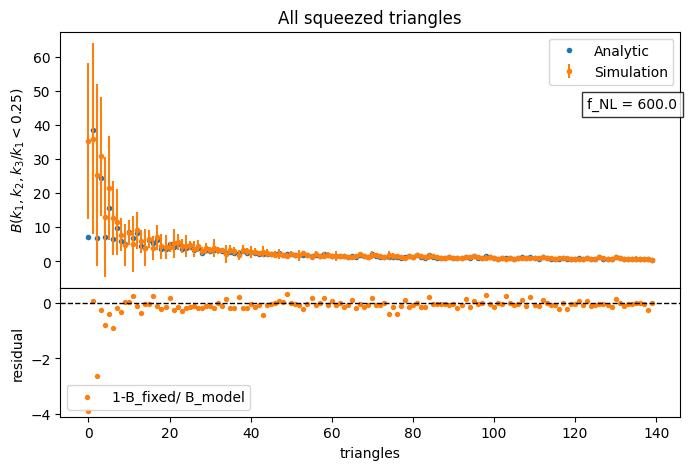

In [33]:
mask = (r3 < 0.25)
bequilateral = Bispectrum_equilateral( k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf, cosmo.f_nl_equi)
btree = Bispectrum_theory(klin, plin, k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf)
bs_model = btree + bequilateral
kk = np.arange(bs_model.shape[0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                               gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)


ax1.plot(kk, bs_model, color = 'C0',ls='', marker='.', label='Analytic')
ax1.errorbar(kk, bs_data[mask],bs_err[mask], color = 'C1',ls='', marker='.', label='Simulation')

ax1.set_yscale('linear')
ax1.set_ylabel(r'$B(k_1,k_2,k_3/k_1 < 0.25)$')
ax1.legend()

ax1.text(0.85, 0.7, f'f_NL = {cosmo.f_nl_equi}',transform=ax1.transAxes,bbox=dict(facecolor='white', alpha=0.8, edgecolor='k'))


ax2.scatter(kk, 1-bs_data[mask]/bs_model, color = 'C1',label=f'1-B_fixed/ B_model',s=8)
ax2.axhline(0, lw=1, color='k', ls='--')

ax2.legend()
ax2.set_xscale('linear')
ax2.set_ylabel('residual')
ax2.set_xlabel('triangles')


ax1.set_title('All squeezed triangles')
plt.show()


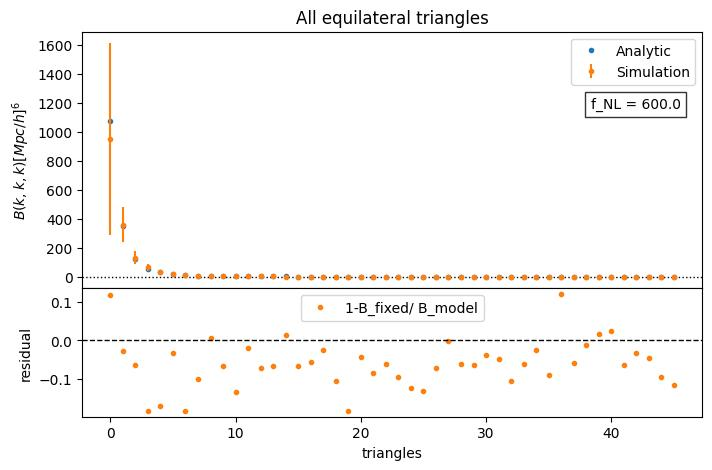

In [ ]:
mask = r3 > 0.9
bequilateral = Bispectrum_equilateral(k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf, cosmo.f_nl_equi)
btree = Bispectrum_theory(klin, plin, k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf)
bs_model = btree + bequilateral
kk = np.arange(bs_model.shape[0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                               gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)


ax1.plot(kk, bs_model, color = 'C0',ls='', marker='.', label='Analytic')
ax1.errorbar(kk, bs_data[mask],bs_err[mask], color = 'C1',ls='', marker='.', label='Simulation')
ax1.axhline(0, color='k', ls=':', lw=1)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_ylabel(r'$B(k,k,k)[Mpc/h]^6$')
ax1.legend()

ax1.text(0.82, 0.7, f'f_NL = {cosmo.f_nl_equi}',transform=ax1.transAxes,bbox=dict(facecolor='white', alpha=0.8, edgecolor='k'))


ax2.plot(kk, 1-bs_data[mask]/bs_model, color = 'C1',ls='', marker='.',label=f'1-B_fixed/ B_model')
ax2.axhline(0, lw=1, color='k', ls='--')


ax2.set_xscale('linear')
ax2.set_ylabel('residual')
ax2.set_xlabel('triangles')


ax2.legend()

ax1.set_title('All equilateral triangles')
plt.show()

(37,)


Text(0.5, 1.0, 'Squeezed triangles with a long mode')

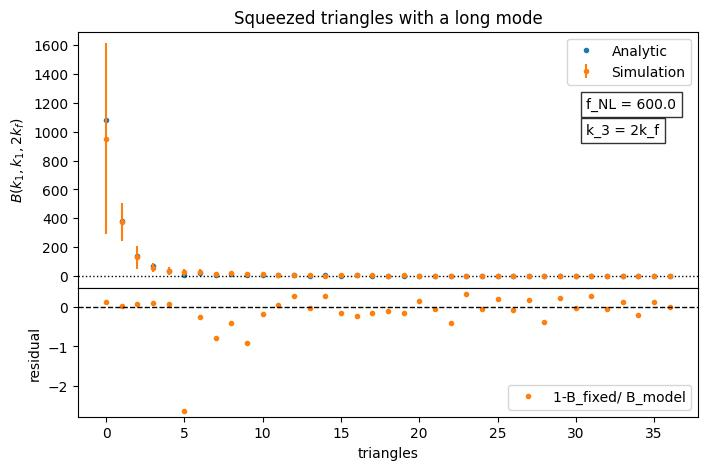

In [ ]:

mask = ( k3_array == 2. ) & (r2>0.8) #some squeezed triangles (k1=k2,k3=6kf)
print(k1_array[mask].shape)

bequilateral = Bispectrum_equilateral(k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf, cosmo.f_nl_equi)
btree = Bispectrum_theory(klin, plin, k1_array[mask]*kf,k2_array[mask]*kf, k3_array[mask]*kf)
bs_model = btree + bequilateral
kk = np.arange(bs_model.shape[0])


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                               gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0)


ax1.plot(kk, bs_model, color = 'C0',ls='', marker='.', label='Analytic')
ax1.errorbar(kk, bs_data[mask],bs_err[mask], color = 'C1',ls='', marker='.', label='Simulation')
ax1.axhline(0, color='k', ls=':', lw=1)


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_ylabel(f'$B(k_1,k_1,{2}k_f)$')
ax1.legend()

ax1.text(0.82, 0.7, f'f_NL = {cosmo.f_nl_equi}',transform=ax1.transAxes,bbox=dict(facecolor='white', alpha=0.8, edgecolor='k'))
ax1.text(0.82, 0.6, f'k_3 = {2}k_f',transform= ax1.transAxes,bbox=dict(facecolor='white', alpha=0.8, edgecolor='k'))



ax2.plot(kk, 1-bs_data[mask]/bs_model, color = 'C1',ls='', marker='.',label=f'1-B_fixed/ B_model')
ax2.axhline(0, lw=1, color='k', ls='--')

ax2.set_xscale('linear')
ax2.set_xlabel('triangles')
ax2.set_ylabel('residual')

ax2.legend()

ax1.set_title('Squeezed triangles with a long mode')
